In [ ]:
# Standard libraries
import os
import sys

# Data processing libraries
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt

# Geospatial libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import contextily as ctx


try:
    # Navigate to the project root from the notebook location
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    os.chdir(project_root)
    print(f"Working directory: {os.getcwd()}")
    
    # Add custom modules to path
    sys.path.append(project_root)
    
    # Import project utilities
    from utils.utils_data import read_netcdf
    
except Exception as e:
    print(f"Error setting up environment: {e}")

Working directory: /home/yuhan/Desktop/Master/yu-ml-weather-analogue


## Data Preprocessing and Loading

This section loads ERA5 reanalysis data and prepares it for visualization. The code reads preprocessed meteorological data that has been organized in a format suitable for machine learning models.


In [2]:
def load_data(variables="tuv", frequency=3, scale="h", method="none", normalized=True):
    """Load preprocessed weather data for visualization
    
    Args:
        variables (str): Variables to load (e.g., 'tuv' for temperature, u-wind, v-wind)
        frequency (int): Temporal frequency (e.g., 3, 6)
        scale (str): Time unit ('h' for hours, 'd' for days)
        method (str): Preprocessing method ('none', 'mean', etc.)
        normalized (bool): Whether data is normalized
        
    Returns:
        list: Loaded data with timestamps
    """
    norm = "_norm" if normalized else ""
    
    # Build the file path
    file_path = f"data/test/{variables}_{frequency}{scale}_{method}{norm}.h5"
    print(f"Loading data from: {file_path}")
    
    # Read the data
    try:
        atmosphere_data = read_netcdf(file_path)
        print(f"Successfully loaded data with {len(atmosphere_data)} time points")
        if len(atmosphere_data) > 0:
            print(f"Data shape: {atmosphere_data[0][1].shape}")
        return atmosphere_data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load sample data
atmosphere_data = load_data(variables="tuv", frequency=3, method="none", normalized=True)

Loading data from: data/test/tuv_3h_none_norm.h5
Error loading data: [Errno 2] No such file or directory: b'/home/yuhan/Desktop/Master/yu-ml-weather-analogue/data/test/tuv_3h_none_norm.h5'


## Map Visualization and Data Plotting

The following cells contain various functions for plotting UK maps and meteorological data. These functions use the Cartopy library to create geographic maps with different projections and features, and visualize ERA5 data.


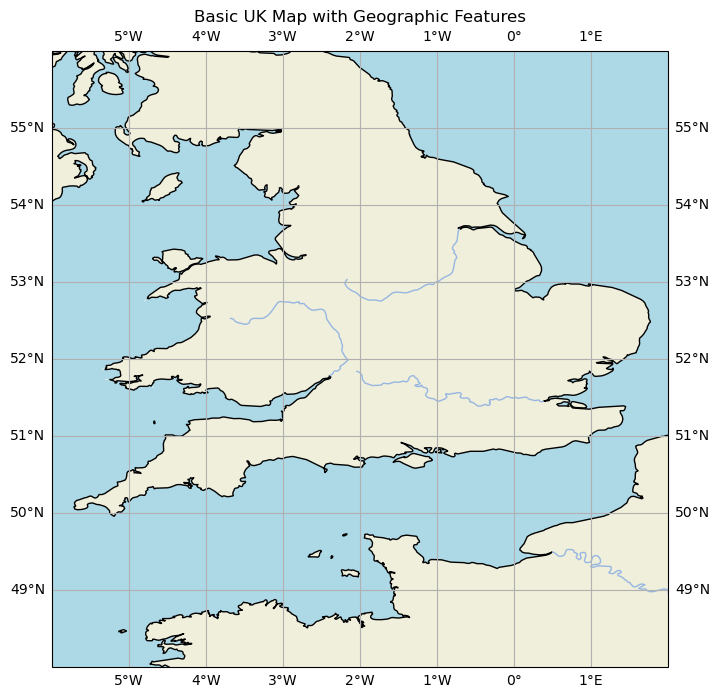

In [3]:
def create_basic_uk_map(figsize=(10, 8), extent=[-6, 2, 48, 56]):
    """Create a basic UK map with coastlines, borders, and lat/lon grid
    
    Args:
        figsize (tuple): Figure size (width, height)
        extent (list): Map extent [lon_min, lon_max, lat_min, lat_max]
        
    Returns:
        tuple: Figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()})
    
    # Set map extent (focus on UK)
    ax.set_extent(extent)  
    
    # Add basic geographic features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    
    # Add lat/lon grid
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    return fig, ax

# Create a basic map
fig, ax = create_basic_uk_map()
plt.title("Basic UK Map with Geographic Features")
plt.show()

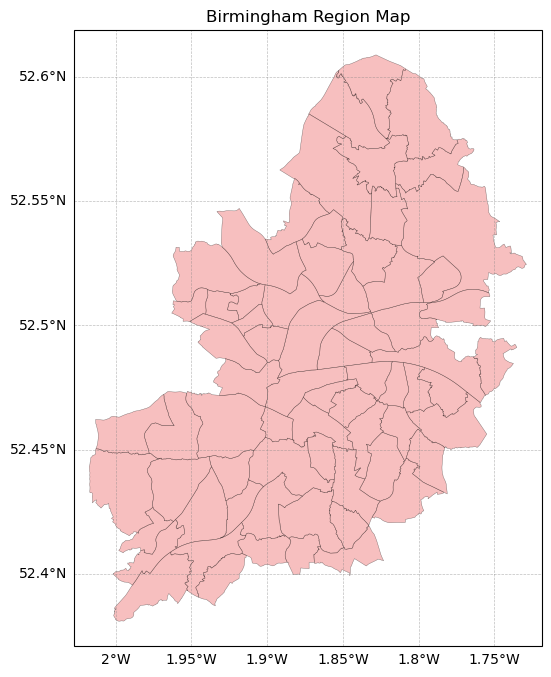

In [4]:
def plot_region_with_cartopy(gdf, region_name="Birmingham", region_column="NAME_3", buffer=0.01):
    """Plot a specific region using Cartopy
    
    Args:
        gdf: GeoPandas GeoDataFrame with administrative regions
        region_name (str): Name of the region to plot
        region_column (str): Column containing region names
        buffer (float): Size of the boundary buffer (degrees)
        
    Returns:
        tuple: Figure and axis objects
    """
    # Filter for target region
    region_gdf = gdf[gdf[region_column] == region_name]
    
    if len(region_gdf) == 0:
        print(f"Error: Region '{region_name}' not found")
        return None, None
    
    # Get region bounds
    lon_min, lat_min, lon_max, lat_max = region_gdf.total_bounds
    
    # Create figure with projection
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set map extent with buffer
    ax.set_extent([lon_min - buffer, lon_max + buffer, lat_min - buffer, lat_max + buffer], 
                 crs=ccrs.PlateCarree())
    
    # Add semi-transparent geographic features
    ax.add_feature(cfeature.COASTLINE, alpha=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    ax.add_feature(cfeature.RIVERS, alpha=0.2)
    ax.add_feature(cfeature.LAKES, alpha=0.2)
    
    # Add administrative region to the map
    region_gdf.plot(ax=ax, edgecolor='black', facecolor='lightcoral', alpha=0.5, 
                   linewidth=0.3, transform=ccrs.PlateCarree())
    
    # Set transparent background
    fig.patch.set_alpha(0)
    
    # Add lat/lon grid lines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    return fig, ax

# Try to plot Birmingham region map with Cartopy
try:
    shapefile_path = 'data/raw/gadm41_GBR_shp/gadm41_GBR_4.shp'
    gdf = gpd.read_file(shapefile_path)
    if 'gdf' in locals() and gdf is not None:
        fig, ax = plot_region_with_cartopy(gdf)
        plt.title("Birmingham Region Map")
        plt.show()
    else:
        print("Error: No valid GeoDataFrame found")
except Exception as e:
    print(f"Error plotting region map: {e}")


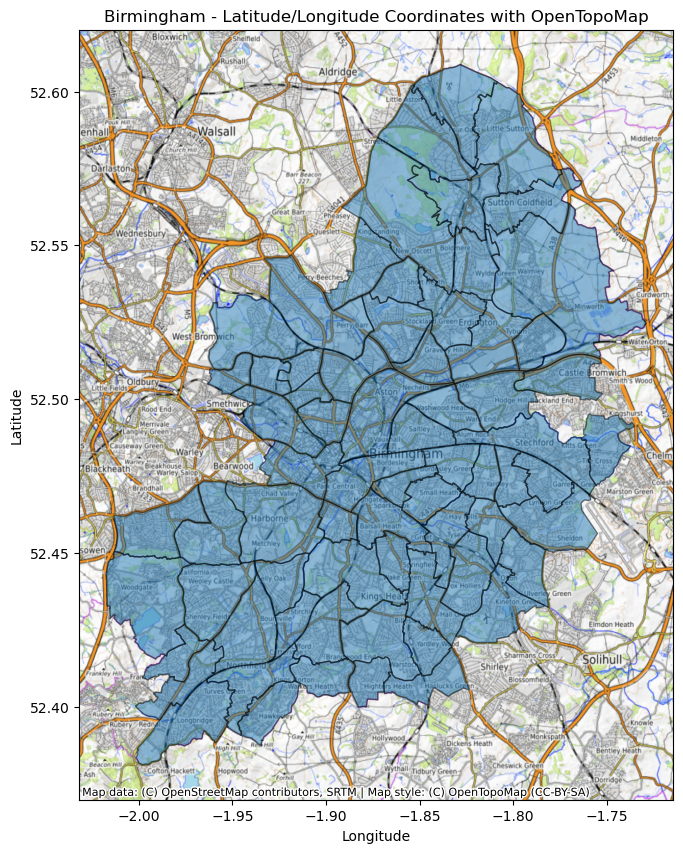

In [5]:
def plot_region_with_latlon_basemap(gdf, region_name="Birmingham", region_column="NAME_3", 
                              provider=ctx.providers.OpenTopoMap, figsize=(10, 10)):
    """Plot a specific region with basemap using latitude/longitude coordinates
    
    Args:
        gdf: GeoPandas GeoDataFrame with administrative regions
        region_name (str): Name of the region to plot
        region_column (str): Column containing region names
        provider: Contextily map provider
        figsize (tuple): Figure size
        
    Returns:
        tuple: Figure and axis objects
    """
    try:
        # Filter for target region and ensure WGS84 lat/lon coordinate system (EPSG:4326)
        region_gdf = gdf[gdf[region_column] == region_name]
        region_gdf = region_gdf.to_crs(epsg=4326)
        
        if len(region_gdf) == 0:
            print(f"Error: Region '{region_name}' not found")
            return None, None
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot region boundaries
        region_gdf.plot(ax=ax, alpha=0.5, edgecolor='black')
        
        # Add basemap, specifying CRS as EPSG:4326
        ctx.add_basemap(ax, crs=region_gdf.crs.to_string(), source=provider)
        
        # Keep coordinate axes to show lat/lon
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        return fig, ax
    
    except Exception as e:
        print(f"Error plotting region with lat/lon basemap: {e}")
        return None, None

# Try to plot Birmingham with lat/lon coordinates and OpenTopoMap basemap
try:
    shapefile_path = 'data/raw/gadm41_GBR_shp/gadm41_GBR_4.shp'
    gdf = gpd.read_file(shapefile_path)
    if 'gdf' in locals() and gdf is not None:
        fig, ax = plot_region_with_latlon_basemap(gdf)
        plt.title("Birmingham - Latitude/Longitude Coordinates with OpenTopoMap")
        plt.show()
    else:
        print("Error: No valid GeoDataFrame found")
except Exception as e:
    print(f"Error plotting region with lat/lon basemap: {e}")


## Summary

This notebook provides a comprehensive set of functions for visualizing weather and geographic data:

1. **Basic Map Creation**: Functions to create UK maps with various levels of detail and features
2. **Weather Data Visualization**: Tools to visualize ERA5 reanalysis data on maps
3. **Region Highlighting**: Capability to highlight specific regions of interest
4. **Specialized Plots**: Custom visualization types for meteorological analysis
5. **Administrative Boundaries**: Tools to work with and visualize administrative regions
6. **Basemap Integration**: Integration with OpenStreetMap and other web map services

These functions can be imported and used in other notebooks for data analysis and result visualization in the Weather Analogue project.